In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.14/25851/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()
sns.set(rc={'axes.facecolor':'white', 'grid.color' : 'lightgrey'}) #<- sets background of plots to be white and makes grid lines black
plt.rcParams["axes.edgecolor"] = "black"
cmap_diff = 'bwr'
cmap_temp = 'hot_r'

In [4]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWFutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')

In [5]:
# Mean state files are stored in Guillaumes directory
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'

In [6]:
# Mean and seas files hold the mean and seasonal mean values for a collection of varibles in the NOW simulation
mean_file = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_mean.nc')
seas_file = xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')

In [7]:
# Loading in EKE file
eke = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_Eddy_Kinetic_Energy.nc')['eke']

In [8]:
# Loading in mean wind speeds
u = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_U_2D_mean.nc')['uos']
v = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_V_2D_mean.nc')['vos']

In [1]:
# Loading in heat flux
hf = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_SST_budget.nc')
cp = 3940 # J/(K*kg). heat capacity of the ocean
rho = 1024 # kg/m^3 average density of sea water - googled
hf = hf * cp * rho # rescaling hf to be in W/m^3

NameError: name 'xr' is not defined

In [105]:
hf['nav_lon'].attrs['units'] = 'degrees_east'
hf['nav_lon'].attrs['long_name'] = 'Longitude'
hf['nav_lon'].attrs['standard_name'] = 'longitude'
hf['nav_lon'] = hf['nav_lon'] % 360

In [106]:
# Breaking up heatflux into consituent pieces
a = ['mhf_geo', 'mhf_ageo', 'ehf_ageo']
adv = -1*hf['ehf_geo']
for i in a:
    adv -= hf[i]
adv = adv.rename('adv')

#shf = surface heat flux, res = residual
shf = hf['shf']
res = hf['residual']

In [191]:
# Defining useful variables
mld = mean_file['mld_dt02']
ehf = -1*hf['ehf_geo'] - hf['ehf_ageo']
ehf_diff = ehf.sel(simulation = 'Future') - ehf.sel(simulation = 'Present') 
mhf = -1*hf['mhf_geo'] - hf['mhf_ageo']
mhf_diff = mhf.sel(simulation = 'Future') - mhf.sel(simulation = 'Present') 
mld_diff = mld.sel(simulation = 'Future') - mld.sel(simulation = 'Present')  
eke_diff = eke.sel(simulation = 'Future') - eke.sel(simulation = 'Present')  
u_diff = u.sel(simulation = 'Future') - u.sel(simulation = 'Present')  
adv_diff = adv.sel(simulation = 'Future') - adv.sel(simulation = 'Present')  

In [13]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [14]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

In [15]:
# Computing average maximum severity per year
maxPastSev = pastMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
maxFutSev = futMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

In [16]:
# Replaces land values with nan. 
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

In [17]:
maxDiffSev = maxFutSev - maxPastSev

In [68]:
cmap_trial = matplotlib.cm.bwr
cmap_trial.set_bad(color = 'k')

## Tasman Sea 
Changes to the EAC cause an increase in severity in this region. These changes can be traced back to increases in westerlies winds which in turn lead to an increase in the EKE (<-- hypothesis)

In [108]:
xmin, xmax = (150, 300)
ymin, ymax = (5, 150)
sev_Ptas = maxPastSev.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))
sev_Ftas = maxFutSev.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))
sev_Dtas = maxDiffSev.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))

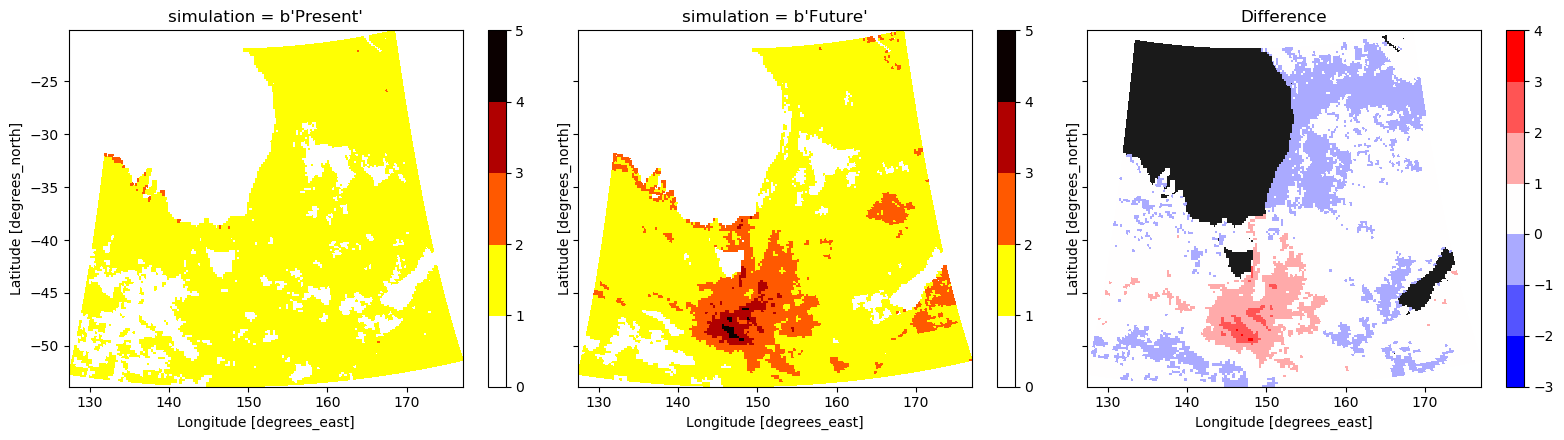

In [136]:
fig, axes = plt.subplots(ncols = 3, figsize = [16, 4.5], sharey = True)
vmin = 0; vmax = 5;
levels = [0,1,2,3,4,5]
levels1 = [-3, -2, -1, 0,1,2,3,4]
sev_Ptas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_temp, ax = axes[0], levels = levels);
sev_Ftas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_temp, ax = axes[1], levels = levels);
sev_Dtas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = axes[2], add_colorbar = False);
sev_Dtas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = axes[2], levels =levels1);

axes[2].set_title('Difference')
fig.tight_layout()
# Note the increase in severity around Eastern Tasmania. That is the region we will be trying to explain in this section

In [193]:
# Indexing the regionally relevant variables
eke_tas = eke_diff.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))
u_tas = u_diff.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))
adv_tas = adv_diff.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))
ehf_tas = ehf_diff.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))
mhf_tas = mhf_diff.isel(y = slice(ymin,ymax), x = slice(xmin, xmax))

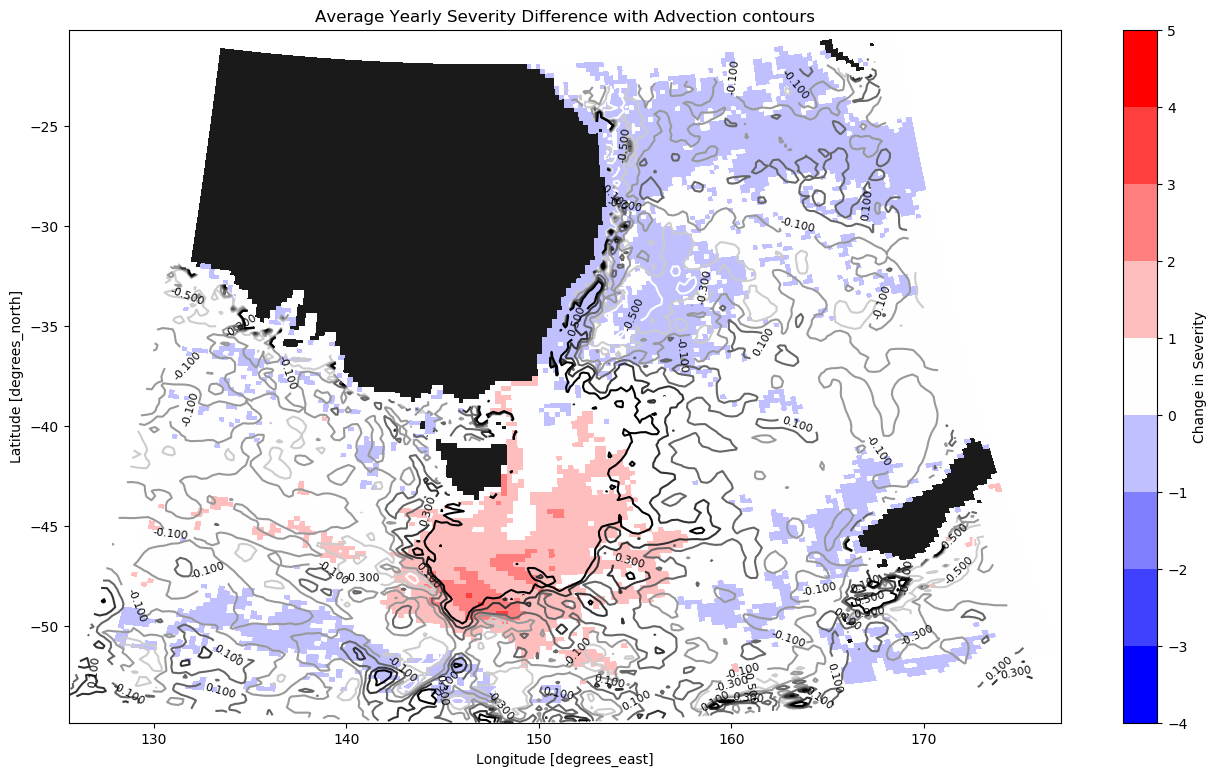

In [190]:
fig, ax = plt.subplots(figsize = (16,9))
sev_Dtas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = ax, add_colorbar = False);
sev_Dtas.plot(cmap = cmap_diff, x = 'nav_lon', y = 'nav_lat', ax = ax, cbar_kwargs = {'label' : 'Change in Severity'}, levels = arange(-4,6))
a = adv_tas.plot.contour(x = 'nav_lon', y = 'nav_lat', vmin = -0.5, vmax = 0.5, levels = 6, cmap = 'binary', ax = ax);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
ax.set_xlabel('Longitude [degrees_east]')
plt.title("Average Yearly Severity Difference with Advection contours");

#plt.savefig('/home/561/rm6294/Documents/Regional Plots/EAC/advcont_sev.png')

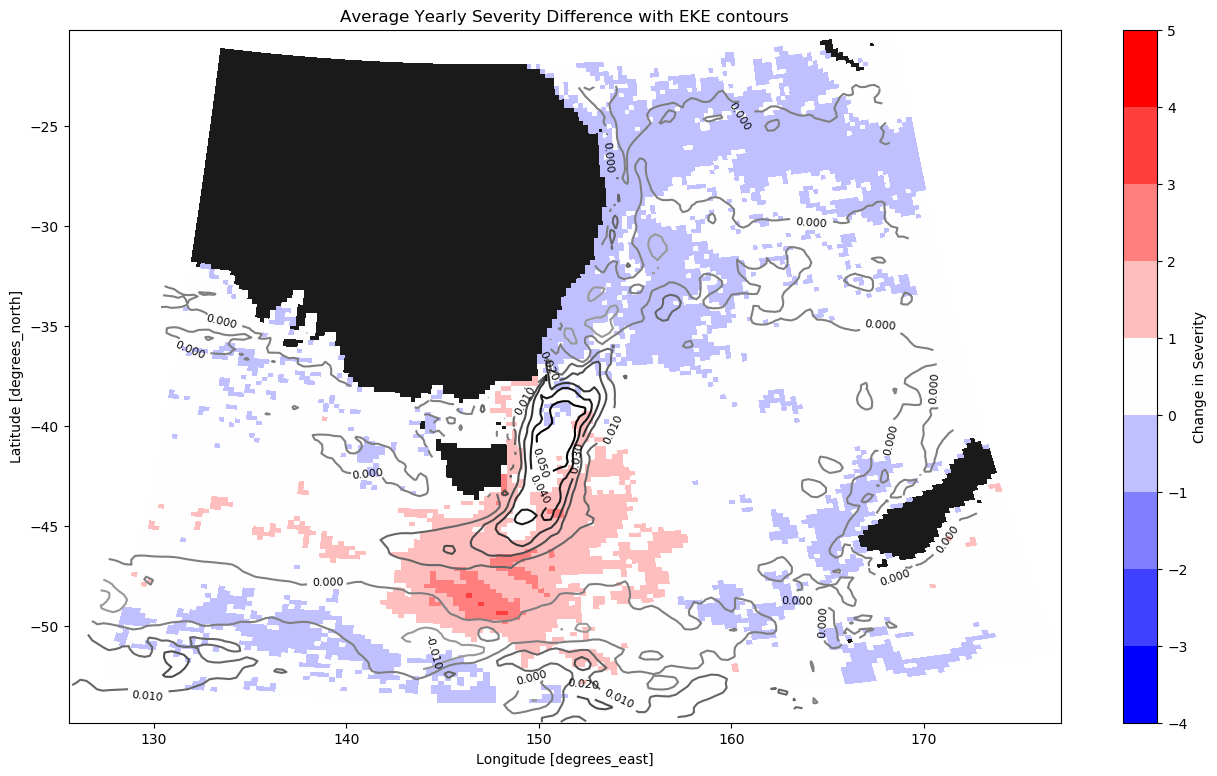

In [171]:
fig, ax = plt.subplots(figsize = (16,9))
sev_Dtas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = ax, add_colorbar = False);
sev_Dtas.plot(cmap = cmap_trial, x = 'nav_lon', y = 'nav_lat', cbar_kwargs = {'label' : 'Change in Severity'}, levels = arange(-4,6), ax = ax)
a = eke_tas.plot.contour(x = 'nav_lon', y = 'nav_lat', vmin = -0.05, vmax = 0.05, levels = 11, cmap = 'binary', ax = ax);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
ax.set_xlabel('Longitude [degrees_east]')
plt.title("Average Yearly Severity Difference with EKE contours");

#plt.savefig('/home/561/rm6294/Documents/Regional Plots/EAC/ekecont_sev.png')

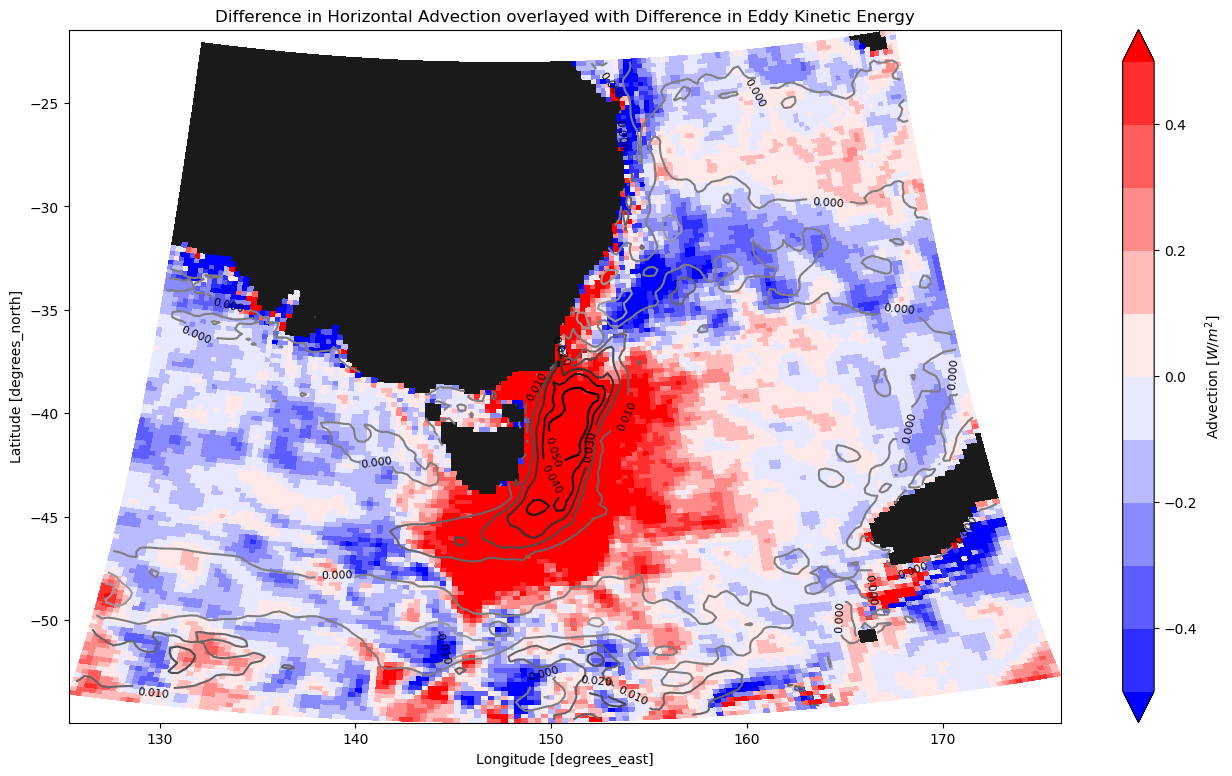

In [170]:
fig, ax = plt.subplots(figsize = (16,9))
adv_tas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = ax, add_colorbar = False);
adv_tas.plot(x = 'nav_lon', y = 'nav_lat',ax = ax, vmin = -0.5, vmax = 0.5, levels = 11, cmap = cmap_diff, cbar_kwargs = {'label':'Advection [$W/m^3$]'});
a = eke_tas.plot.contour(x = 'nav_lon', y = 'nav_lat', vmin = -0.05, vmax = 0.05, levels = 11, cmap = 'binary', ax = ax);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
ax.set_xlabel('Longitude [degrees_east]')
ax.set_title('Difference in Horizontal Advection overlayed with Difference in Eddy Kinetic Energy');

plt.savefig('/home/561/rm6294/Documents/Regional Plots/EAC/ekecont_adv.png')

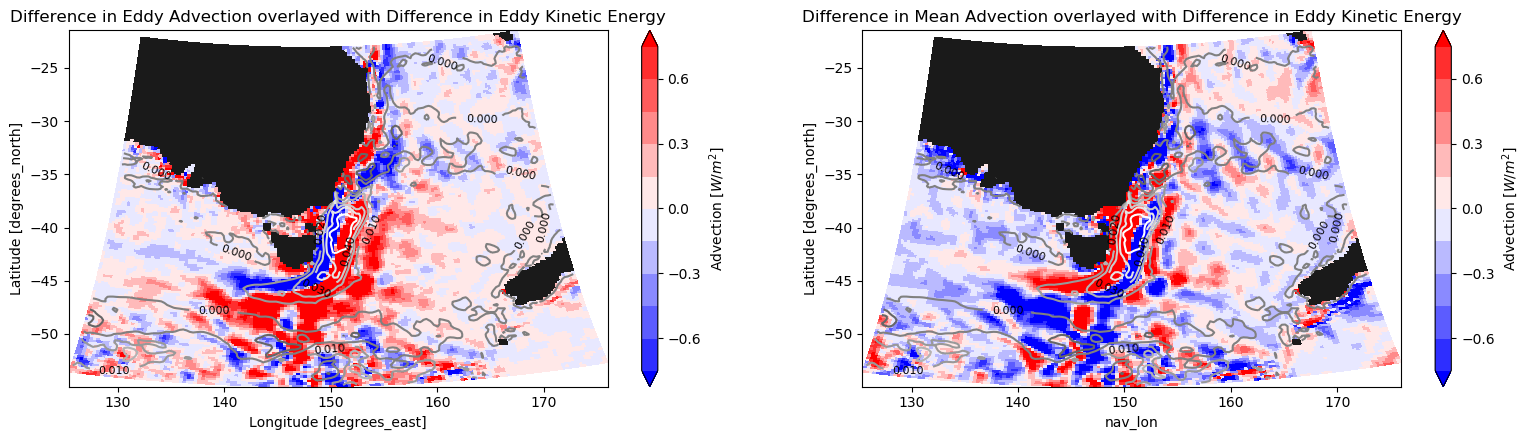

In [226]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,4.5))
ehf_tas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = ax[0], add_colorbar = False);
ehf_tas.plot(x = 'nav_lon', y = 'nav_lat',ax = ax[0], vmin = -0.75, vmax = 0.75, levels = 11, cmap = cmap_diff, cbar_kwargs = {'label':'Advection [$W/m^3$]'});
a = eke_tas.plot.contour(x = 'nav_lon', y = 'nav_lat', vmin = -0.05, vmax = 0.05, levels = 11, cmap = 'binary_r', ax = ax[0]);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
ax[0].set_xlabel('Longitude [degrees_east]')
ax[0].set_title('Difference in Eddy Advection overlayed with Difference in Eddy Kinetic Energy');

mhf_tas.plot(x = 'nav_lon', y = 'nav_lat', cmap = cmap_trial, ax = ax[1], add_colorbar = False);
mhf_tas.plot(x = 'nav_lon', y = 'nav_lat',ax = ax[1], vmin = -0.75, vmax = 0.75, levels = 11, cmap = cmap_diff, cbar_kwargs = {'label':'Advection [$W/m^3$]'});
a = eke_tas.plot.contour(x = 'nav_lon', y = 'nav_lat', vmin = -0.05, vmax = 0.05, levels = 11, cmap = 'binary_r', ax = ax[1]);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
ax[1].set_title('Difference in Mean Advection overlayed with Difference in Eddy Kinetic Energy');

plt.tight_layout()
plt.savefig('/home/561/rm6294/Documents/Regional Plots/EAC/ekeCont_advConstituents.png')

## Change in MLD region

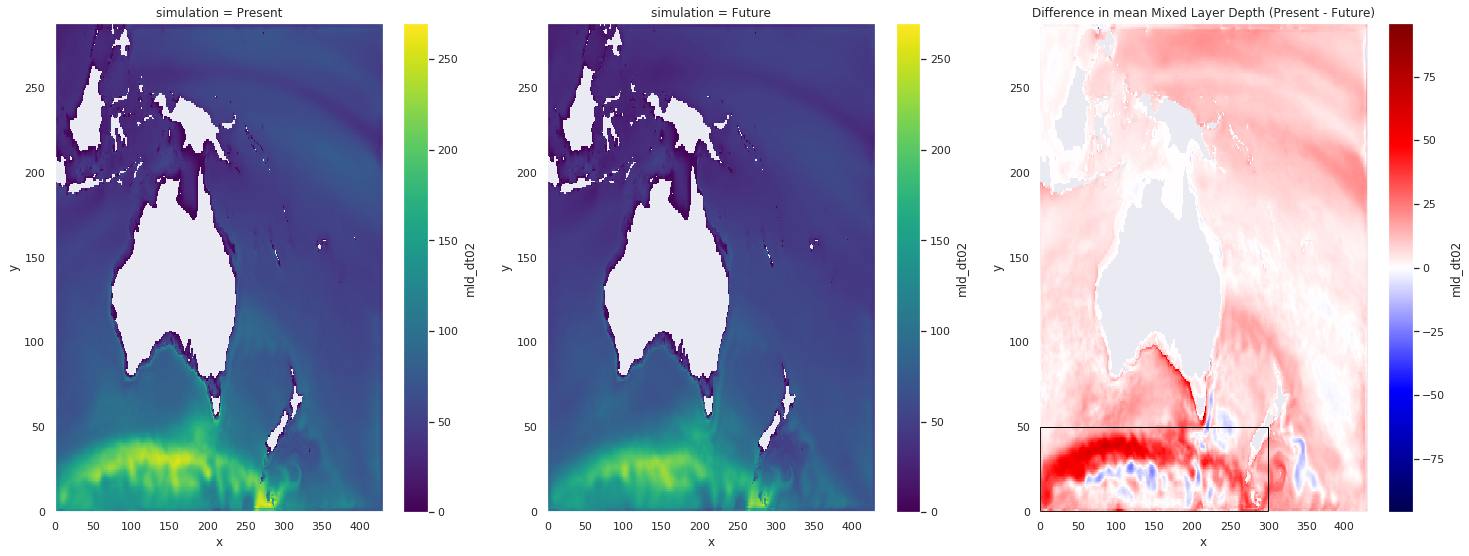

In [232]:
f, axes = plt.subplots(1,3, figsize = [25,9])
(vmin, vmax) = (0, 270)
mld.sel(simulation = 'Present').plot(ax = axes[0], vmin = vmin, vmax = vmax);
mld.sel(simulation = 'Future').plot(ax = axes[1], vmin = vmin, vmax = vmax);
(mld.sel(simulation = 'Present') - mld.sel(simulation = 'Future')).plot(cmap = 'seismic', ax = axes[2]);

axes[2].set_title('Difference in mean Mixed Layer Depth (Present - Future)');

# Plotting rectangle to show region
axes[2].add_patch(Rectangle((0, 0), 300, 50, fill = False, color= 'black'));
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/MLD_diff.png')

In [110]:
diffMHW = futMHW - pastMHW

##### Region of interest is between x = (0, 300) and y = (0, 50)

In [120]:
mld_pReg = mld.sel(simulation = 'Present').isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})
mld_fReg = mld.sel(simulation = 'Future').isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})
mld_diffReg = mld_fReg - mld_pReg

In [121]:
eke_mldReg = eke_diff.isel(y = slice(5,55), x = slice(5, 300))

In [122]:
mldRegp = pastMHW.isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})
mldRegf = futMHW.isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})

In [123]:
mldReg_PSev = mldRegp.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
mldReg_PSev = xr.where(mldReg_PSev == 0, np.nan, mldReg_PSev)

In [124]:
mldReg_FSev = mldRegf.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
mldReg_FSev = xr.where(mldReg_FSev == 0, np.nan, mldReg_FSev)

In [199]:
mldReg_diff_Sev = mldReg_FSev - mldReg_PSev
udiff =  (u.sel(simulation = 'Future') - u.sel(simulation = 'Present')).isel(y = slice(5,55), x = slice(5, 300))
vdiff =  (v.sel(simulation = 'Future') - v.sel(simulation = 'Present')).isel(y = slice(5,55), x = slice(5, 300))

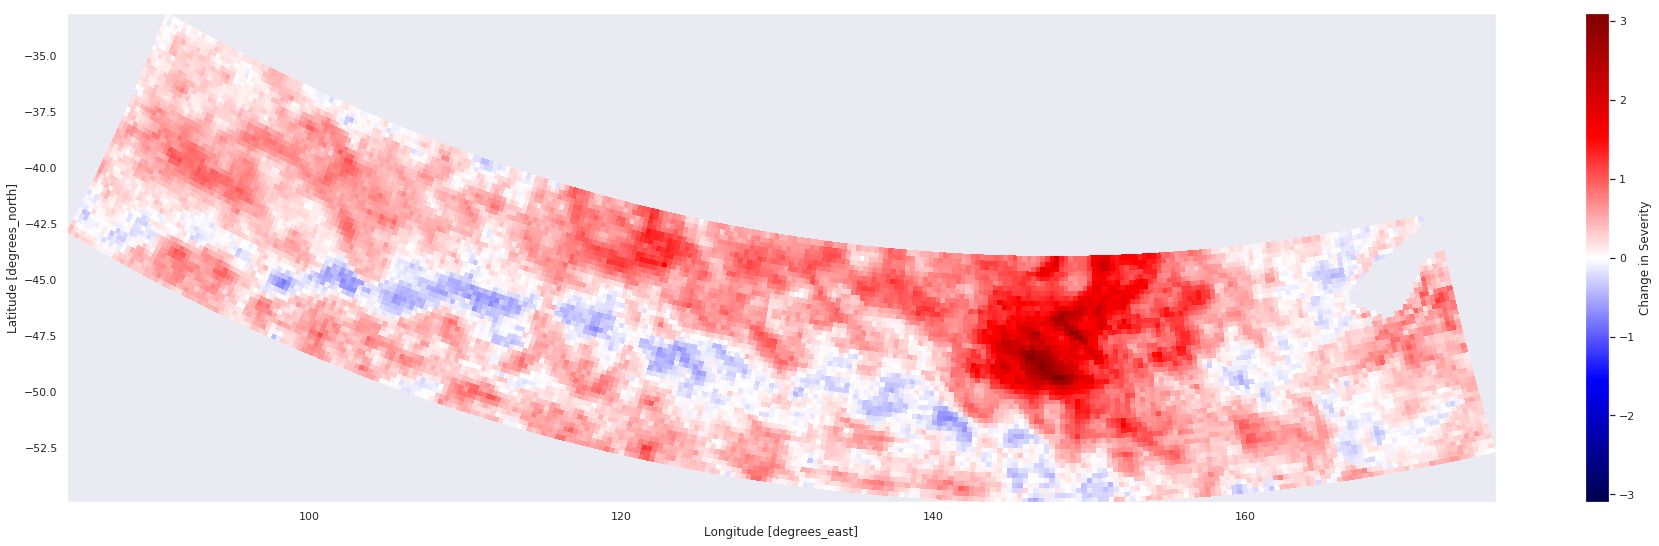

In [233]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9), cbar_kwargs = {'label' : 'Change in Severity'})

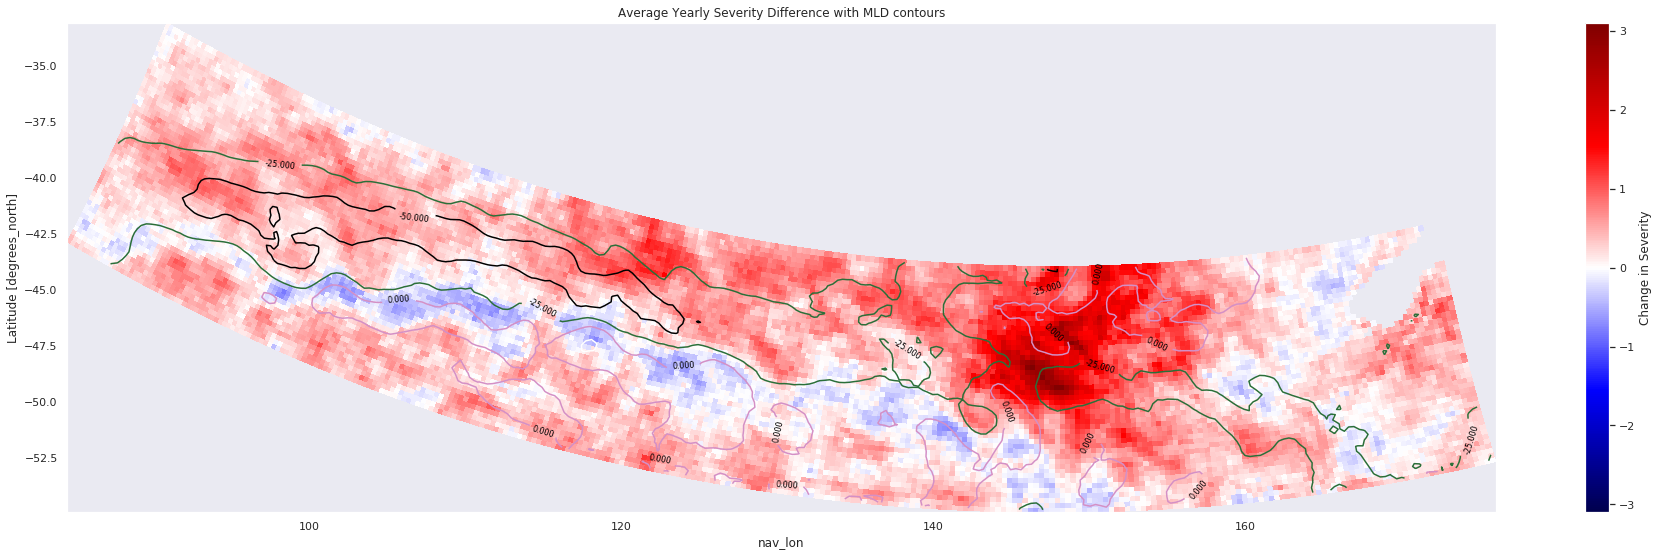

In [208]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9), cbar_kwargs = {'label' : 'Change in Severity'})
a = mld_diffReg.plot.contour(x = 'nav_lon', y = 'nav_lat', cmap = 'cubehelix', levels = [-50, -25, 0, 25]);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
plt.title("Average Yearly Severity Difference with MLD contours")
plt.savefig('/home/561/rm6294/Documents/Regional Plots/MLD region/maxYearlySev_MLDContour.png')

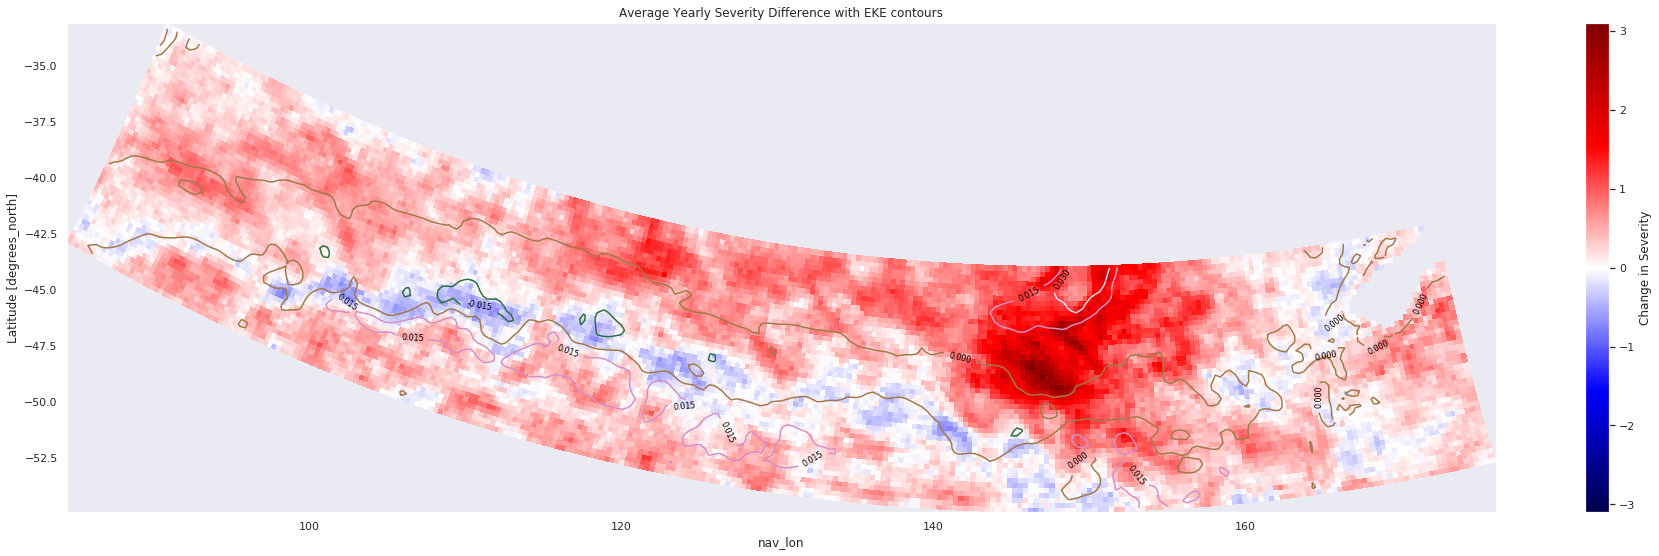

In [209]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9), cbar_kwargs = {'label' : 'Change in Severity'})
a = eke_mldReg.plot.contour(x = 'nav_lon', y = 'nav_lat', cmap = 'cubehelix');
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
plt.title('Average Yearly Severity Difference with EKE contours')
plt.savefig('/home/561/rm6294/Documents/Regional Plots/MLD region/maxYearlySev_EKEContour.png')

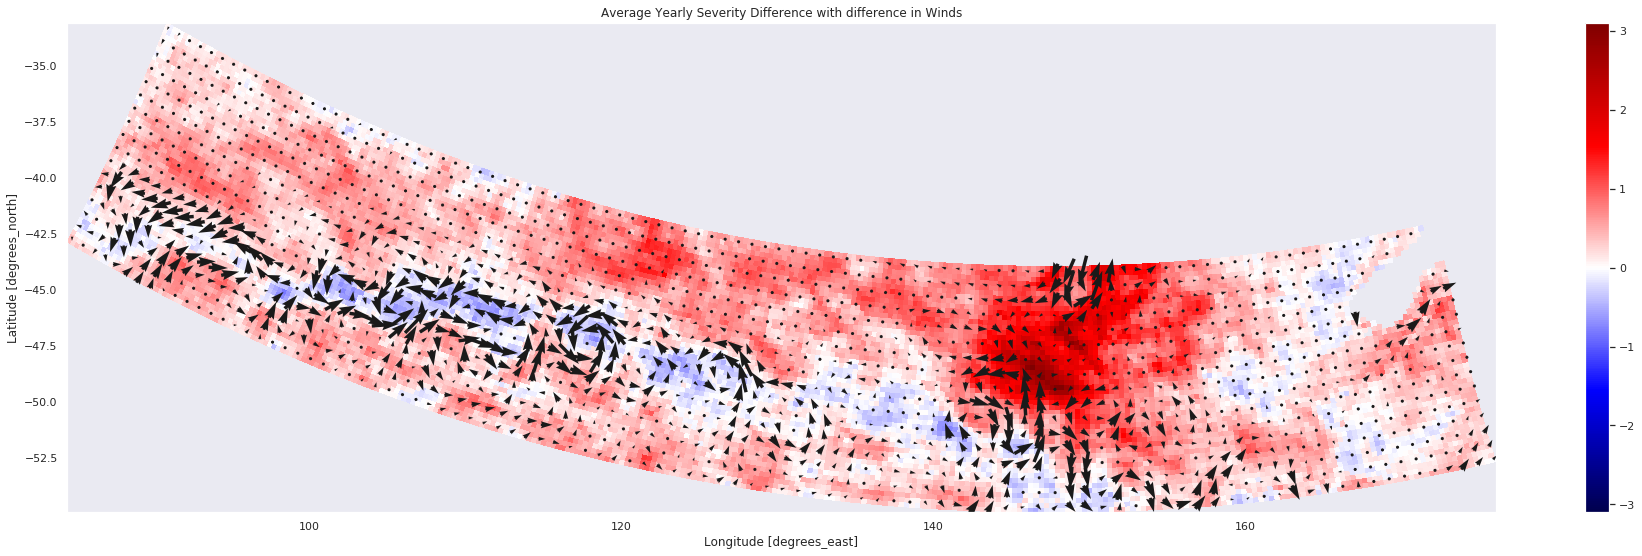

In [210]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9))
skip = 3
plt.quiver(udiff['nav_lon'][::skip, ::skip], vdiff['nav_lat'][::skip, ::skip], udiff[::skip, ::skip], vdiff[::skip, ::skip], pivot='middle', angles='xy', scale_units='xy',  scale = 0.1);
plt.title('Average Yearly Severity Difference with difference in Winds')
plt.savefig('/home/561/rm6294/Documents/Regional Plots/MLD region/maxYearlySev_windOverlay.png')

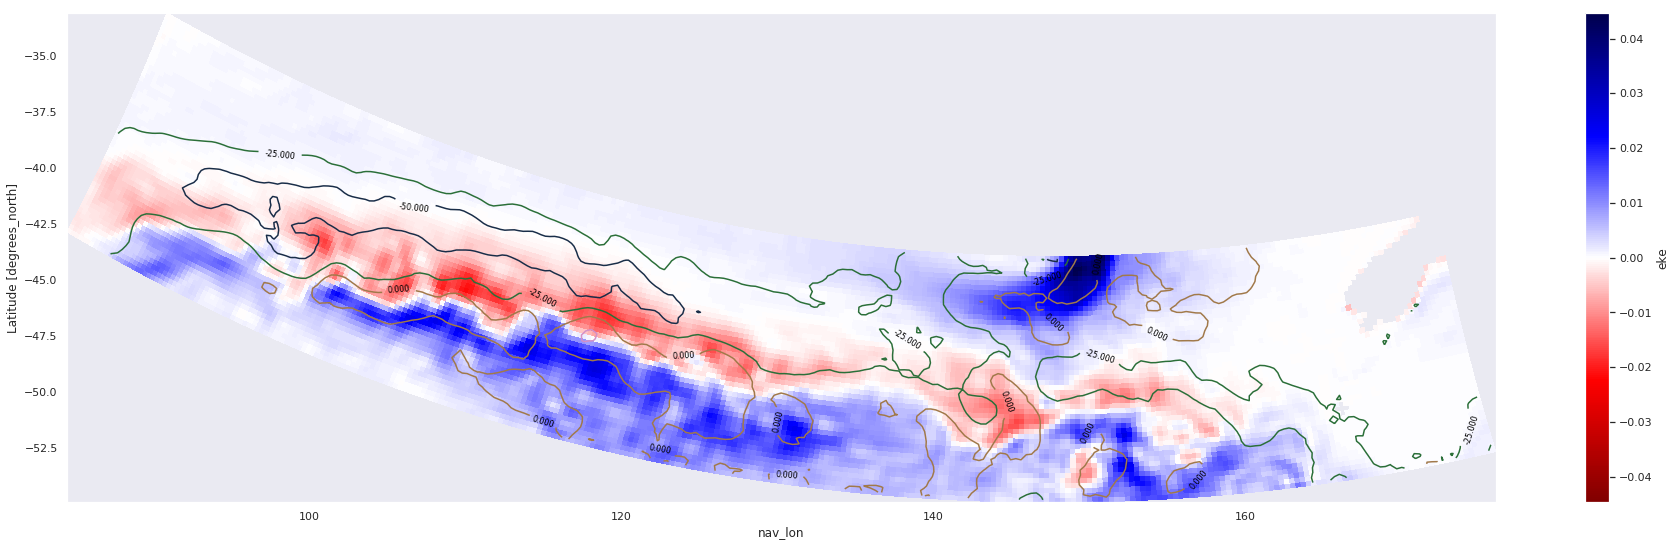

In [152]:
eke_mldReg.plot(cmap = 'seismic_r', x = 'nav_lon', y = 'nav_lat', figsize = (32,9))
a = mld_diffReg.plot.contour(x = 'nav_lon', y = 'nav_lat', cmap = 'cubehelix');
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');